<a href="https://colab.research.google.com/github/IggyZhao/Python-Skiil-Iggy/blob/master/Time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
import numpy as np
import warnings
import scipy
from datetime import timedelta

# Forceasting with decompasable model
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = [20,8]

# Prepare the data

In [ ]:
# Load the data
filepath = 'train_1.csv'
train = pd.read_csv(filepath)

In [ ]:
train.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,2015-07-12,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-18,2015-07-19,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-25,2015-07-26,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-01,2015-08-02,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-08,...,2016-11-22,2016-11-23,2016-11-24,2016-11-25,2016-11-26,2016-11-27,2016-11-28,2016-11-29,2016-11-30,2016-12-01,2016-12-02,2016-12-03,2016-12-04,2016-12-05,2016-12-06,2016-12-07,2016-12-08,2016-12-09,2016-12-10,2016-12-11,2016-12-12,2016-12-13,2016-12-14,2016-12-15,2016-12-16,2016-12-17,2016-12-18,2016-12-19,2016-12-20,2016-12-21,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,24.0,19.0,10.0,14.0,15.0,8.0,16.0,8.0,8.0,16.0,7.0,11.0,10.0,20.0,18.0,15.0,14.0,49.0,10.0,16.0,18.0,8.0,5.0,9.0,7.0,13.0,9.0,7.0,4.0,11.0,...,24.0,14.0,11.0,204.0,14.0,45.0,33.0,28.0,18.0,14.0,47.0,15.0,14.0,18.0,20.0,14.0,16.0,14.0,20.0,60.0,22.0,15.0,17.0,19.0,18.0,21.0,21.0,47.0,65.0,17.0,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,4.0,41.0,65.0,57.0,38.0,20.0,62.0,44.0,15.0,10.0,47.0,24.0,17.0,22.0,9.0,39.0,13.0,11.0,12.0,21.0,19.0,9.0,15.0,33.0,8.0,8.0,7.0,13.0,2.0,23.0,...,14.0,15.0,15.0,11.0,20.0,13.0,19.0,621.0,57.0,17.0,23.0,19.0,21.0,47.0,28.0,22.0,22.0,65.0,27.0,17.0,17.0,13.0,9.0,18.0,22.0,17.0,15.0,22.0,23.0,19.0,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,4.0,1.0,1.0,1.0,6.0,8.0,6.0,4.0,5.0,1.0,2.0,3.0,8.0,8.0,6.0,6.0,2.0,2.0,3.0,2.0,4.0,3.0,3.0,5.0,3.0,5.0,4.0,2.0,5.0,1.0,...,9.0,3.0,5.0,4.0,0.0,1.0,4.0,5.0,8.0,8.0,1.0,1.0,2.0,5.0,3.0,3.0,3.0,7.0,3.0,9.0,8.0,3.0,210.0,5.0,4.0,6.0,2.0,2.0,4.0,3.0,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,16.0,16.0,11.0,23.0,145.0,14.0,17.0,85.0,4.0,30.0,22.0,9.0,10.0,11.0,7.0,7.0,11.0,9.0,11.0,44.0,8.0,14.0,19.0,10.0,17.0,17.0,10.0,7.0,10.0,1.0,...,7.0,10.0,7.0,10.0,14.0,17.0,11.0,9.0,11.0,5.0,10.0,8.0,17.0,13.0,23.0,40.0,16.0,17.0,41.0,17.0,8.0,9.0,18.0,12.0,12.0,18.0,13.0,18.0,23.0,10.0,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14.0,13.0,15.0,14.0,16.0,9.0,178.0,64.0,12.0,10.0,11.0,6.0,8.0,7.0,9.0,8.0,5.0,11.0,8.0,4.0,15.0,5.0,8.0,8.0,6.0,7.0,15.0,4.0,11.0,7.0,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [ ]:
# Pivot the table
train_flattened = pd.melt(train[list(train.columns[10:300])+['Page']], id_vars='Page', var_name='date', value_name='Visits')
train_flattened['date'] = train_flattened['date'].astype('datetime64[ns]')
train_flattened.head()

,Page,date,Visits
0,2NE1_zh.wikipedia.org_all-access_spider,2015-07-10,24.0
1,2PM_zh.wikipedia.org_all-access_spider,2015-07-10,4.0
2,3C_zh.wikipedia.org_all-access_spider,2015-07-10,4.0
3,4minute_zh.wikipedia.org_all-access_spider,2015-07-10,16.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,2015-07-10,NaN


/usr/local/lib/python2.7/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


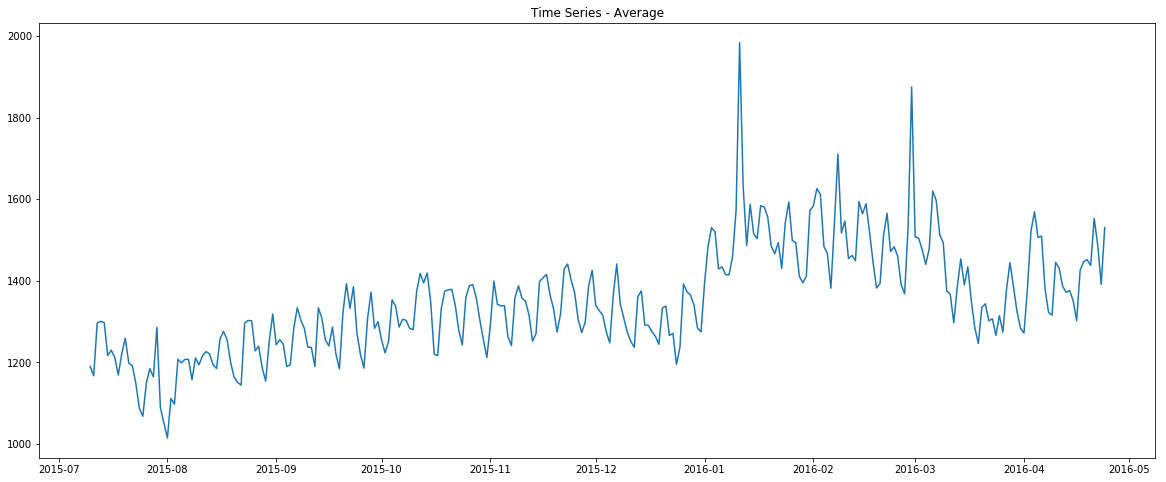

In [ ]:
mean_group = train_flattened[['Page','date','Visits']].groupby(['date'])['Visits'].mean()
plt.plot(mean_group)
plt.title('Time Series - Average')
plt.show()

# Check the stationarity

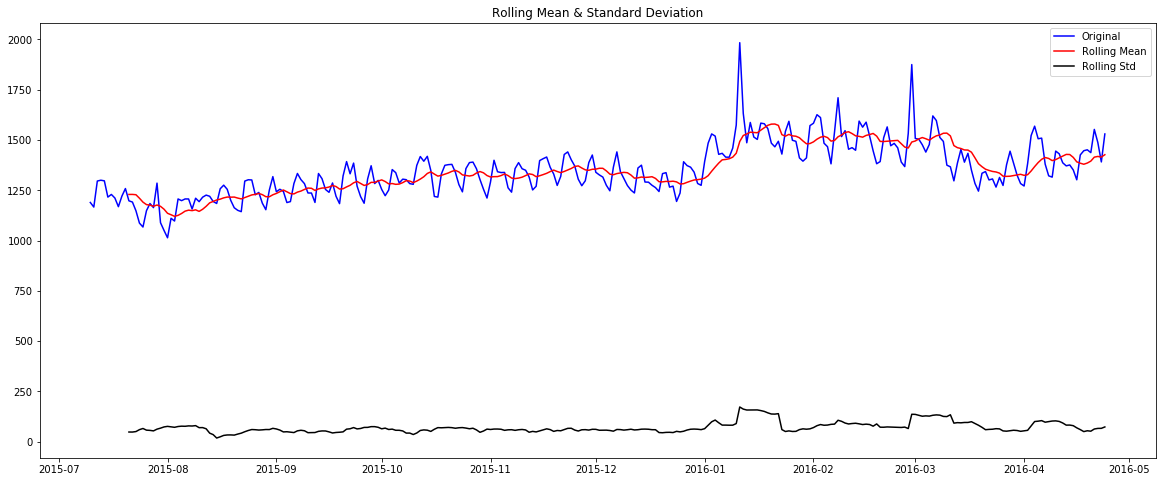

Results of Dickey-Fuller Test:
Test Statistic                  -1.964769
p-value                          0.302231
#Lags Used                      14.000000
Number of Observations Used    275.000000
Critical Value (5%)             -2.872108
Critical Value (1%)             -3.454355
Critical Value (10%)            -2.572401
dtype: float64


In [ ]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean() 
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

test_stationarity(mean_group)

# How to transform to a stationary process

## Moving average

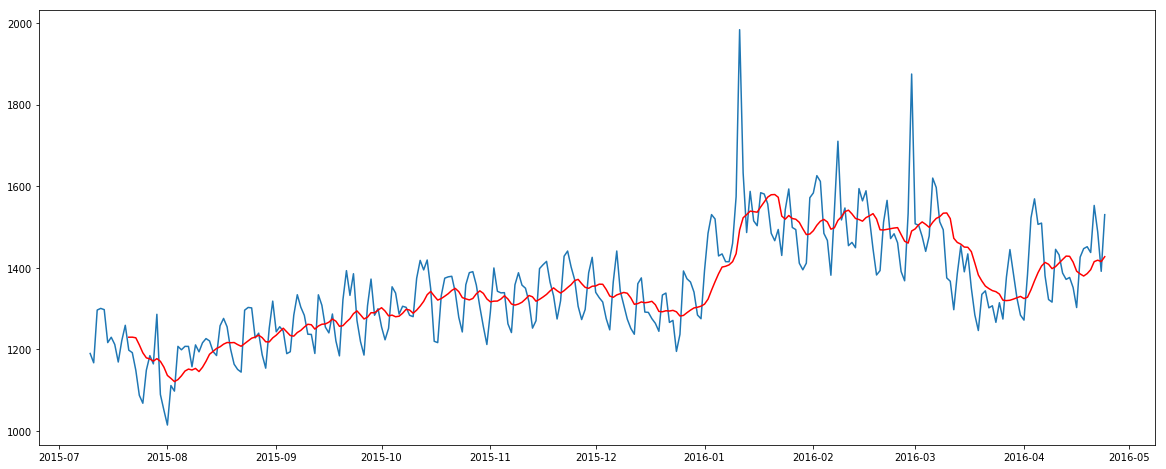

In [ ]:
moving_avg = mean_group.rolling(12).mean()
plt.plot(mean_group)
plt.plot(moving_avg, color='red')

In [ ]:
moving_avg_diff = mean_group - moving_avg
moving_avg_diff.head(12)

date
2015-07-10         NaN
2015-07-11         NaN
2015-07-12         NaN
2015-07-13         NaN
2015-07-14         NaN
2015-07-15         NaN
2015-07-16         NaN
2015-07-17         NaN
2015-07-18         NaN
2015-07-19         NaN
2015-07-20         NaN
2015-07-21   -31.72006
Name: Visits, dtype: float64

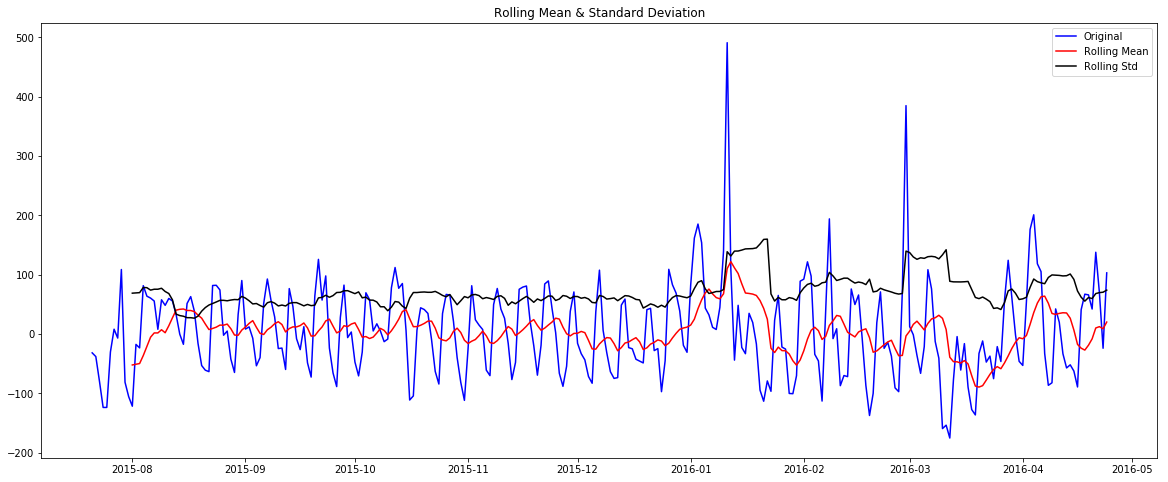

Results of Dickey-Fuller Test:
Test Statistic                  -4.767407
p-value                          0.000063
#Lags Used                      14.000000
Number of Observations Used    264.000000
Critical Value (5%)             -2.872551
Critical Value (1%)             -3.455365
Critical Value (10%)            -2.572638
dtype: float64


In [ ]:
moving_avg_diff.dropna(inplace=True)
test_stationarity(moving_avg_diff)

## Exponential weighted moving average

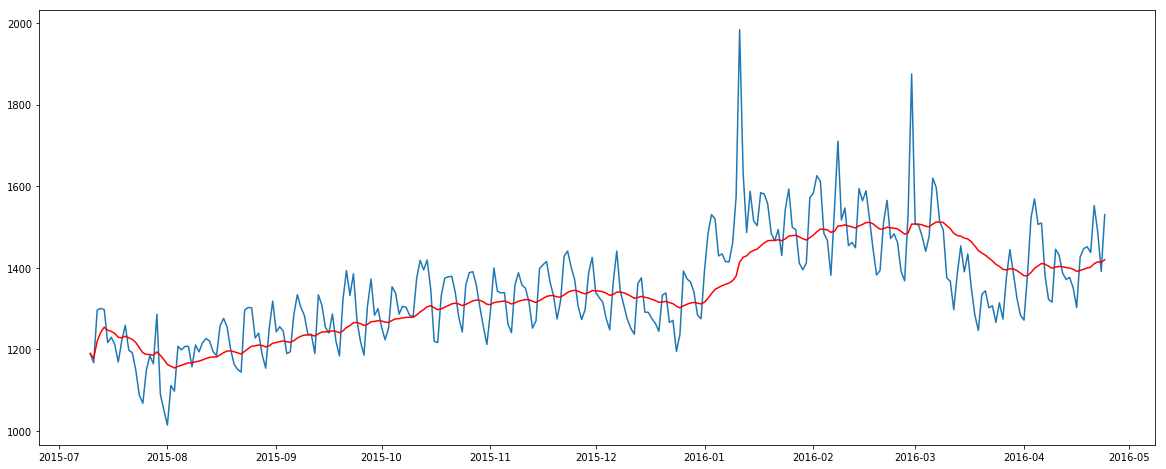

In [ ]:
expwighted_avg = mean_group.ewm(halflife=12).mean()
plt.plot(mean_group)
plt.plot(expwighted_avg, color='red')

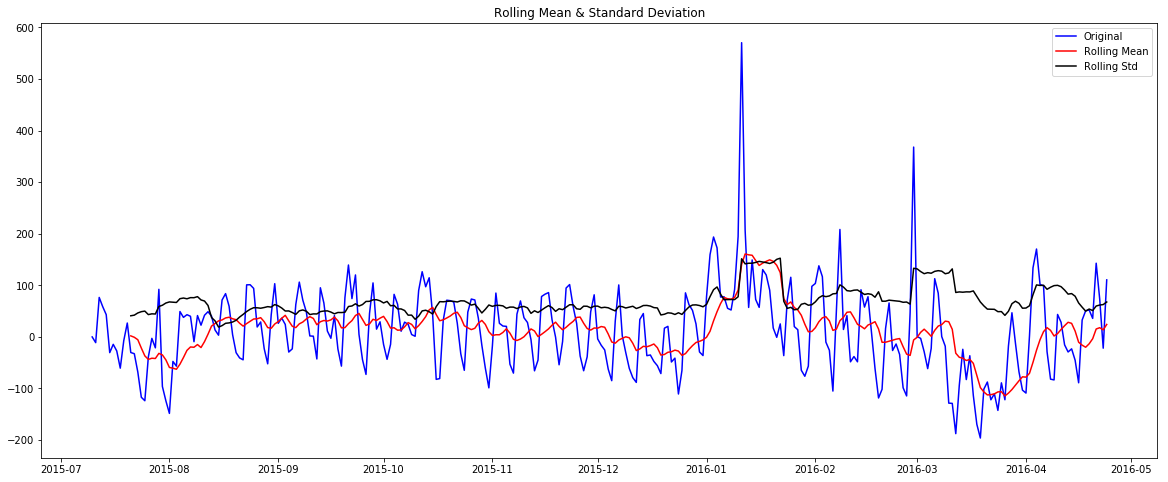

Results of Dickey-Fuller Test:
Test Statistic                  -3.654931
p-value                          0.004794
#Lags Used                      14.000000
Number of Observations Used    275.000000
Critical Value (5%)             -2.872108
Critical Value (1%)             -3.454355
Critical Value (10%)            -2.572401
dtype: float64


In [ ]:
ewma_diff = mean_group - expwighted_avg
test_stationarity(ewma_diff)

## Differencing

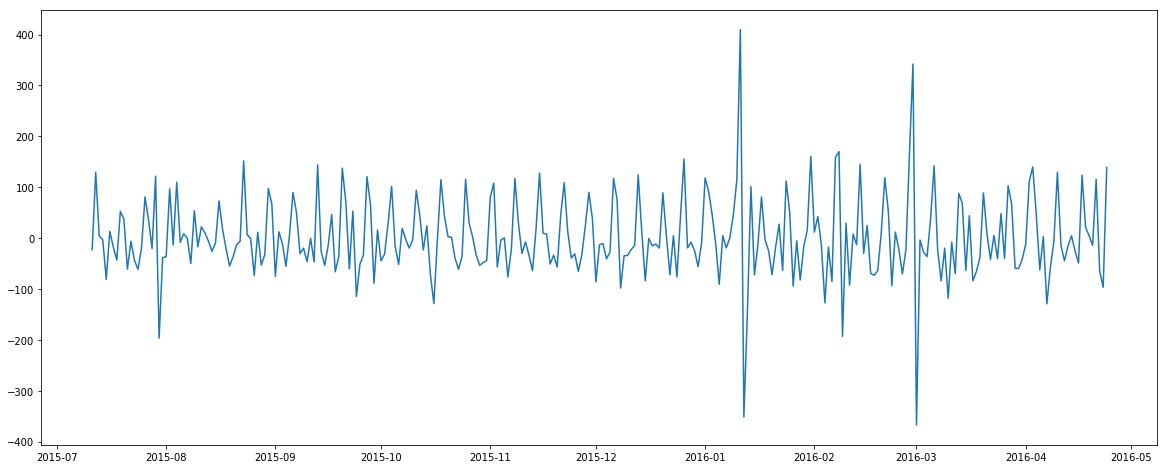

In [ ]:
mean_group_diff = mean_group - mean_group.shift()
plt.plot(mean_group_diff)

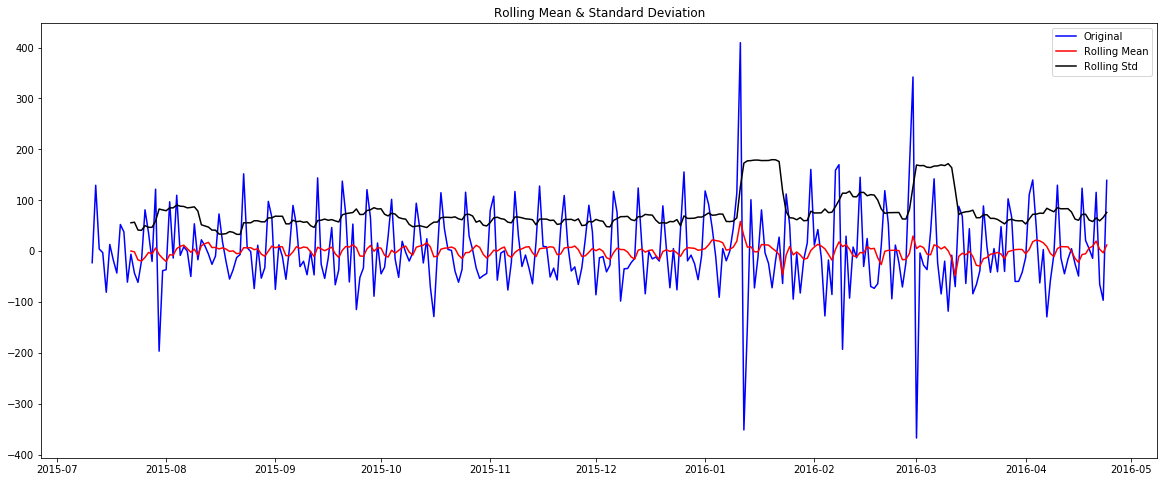

Results of Dickey-Fuller Test:
Test Statistic                  -4.670382
p-value                          0.000096
#Lags Used                      13.000000
Number of Observations Used    275.000000
Critical Value (5%)             -2.872108
Critical Value (1%)             -3.454355
Critical Value (10%)            -2.572401
dtype: float64


In [ ]:
mean_group_diff.dropna(inplace=True)
test_stationarity(mean_group_diff)

## Decomposing

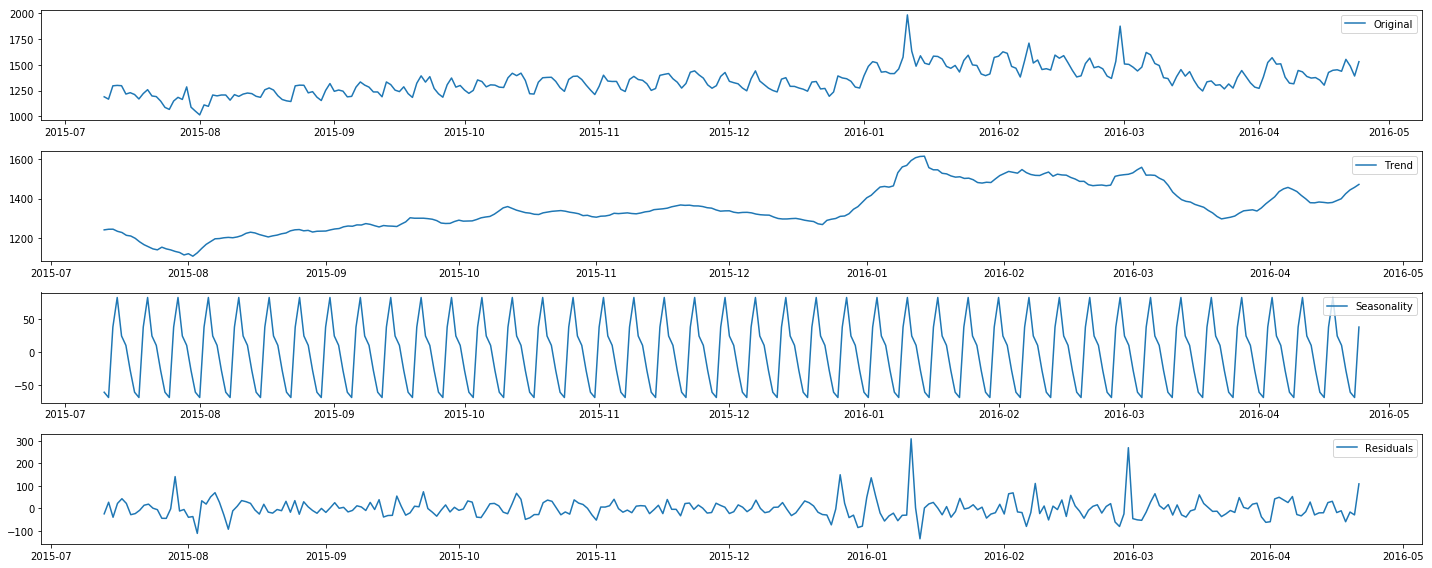

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(mean_group)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(mean_group, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

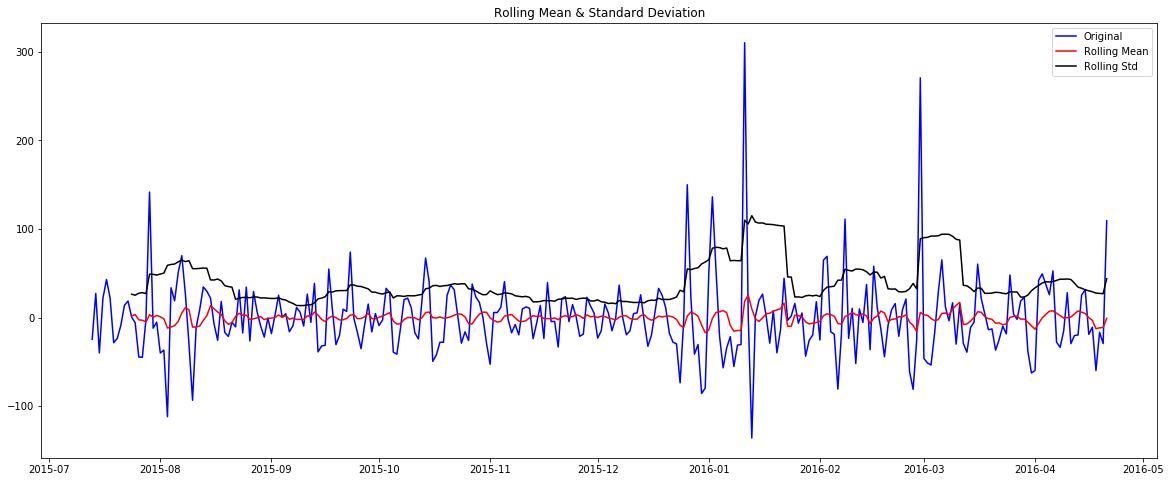

Results of Dickey-Fuller Test:
Test Statistic                -1.111005e+01
p-value                        3.679340e-20
#Lags Used                     7.000000e+00
Number of Observations Used    2.760000e+02
Critical Value (5%)           -2.872070e+00
Critical Value (1%)           -3.454267e+00
Critical Value (10%)          -2.572381e+00
dtype: float64


In [ ]:
mean_group_decompose = residual
mean_group_decompose.dropna(inplace=True)
test_stationarity(mean_group_decompose)

# Forecasting

## ACF and PACF

In [ ]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(residual, nlags=20)
lag_pacf = pacf(residual, nlags=20, method='ols')

/usr/local/lib/python2.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


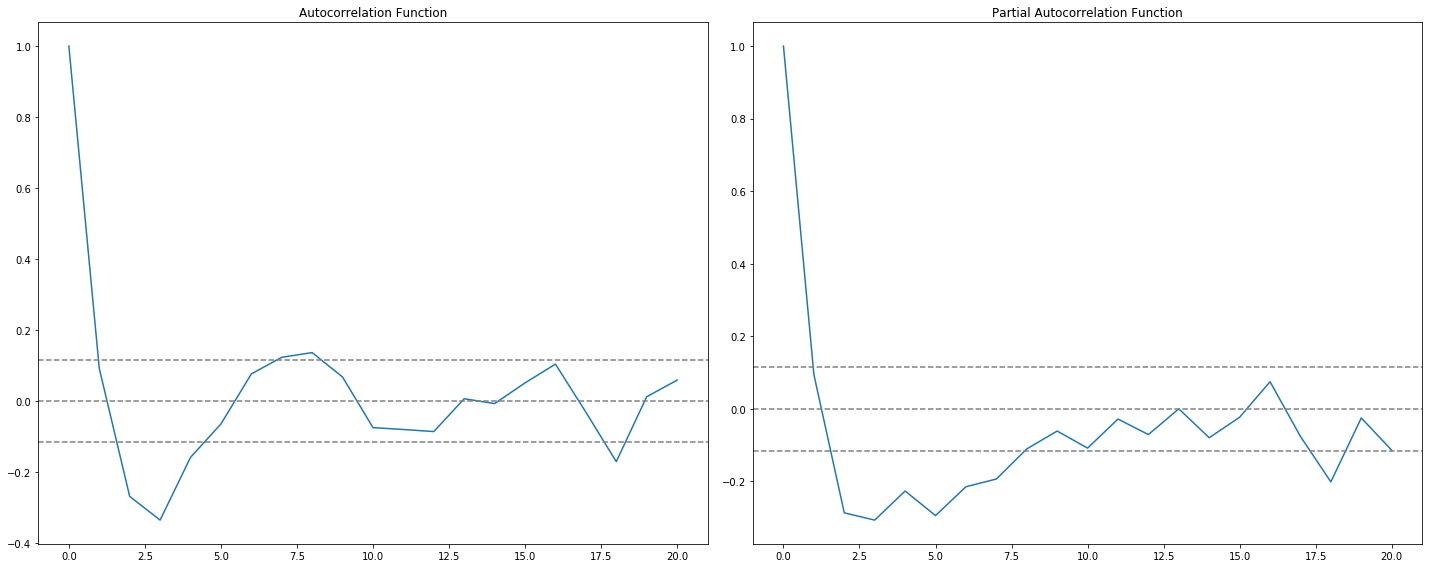

In [ ]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(mean_group_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(mean_group_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(mean_group_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(mean_group_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

## AR model

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tools.eval_measures import aicc

/usr/local/lib/python2.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Text(0.5,1,'RSS: 537412.2140')

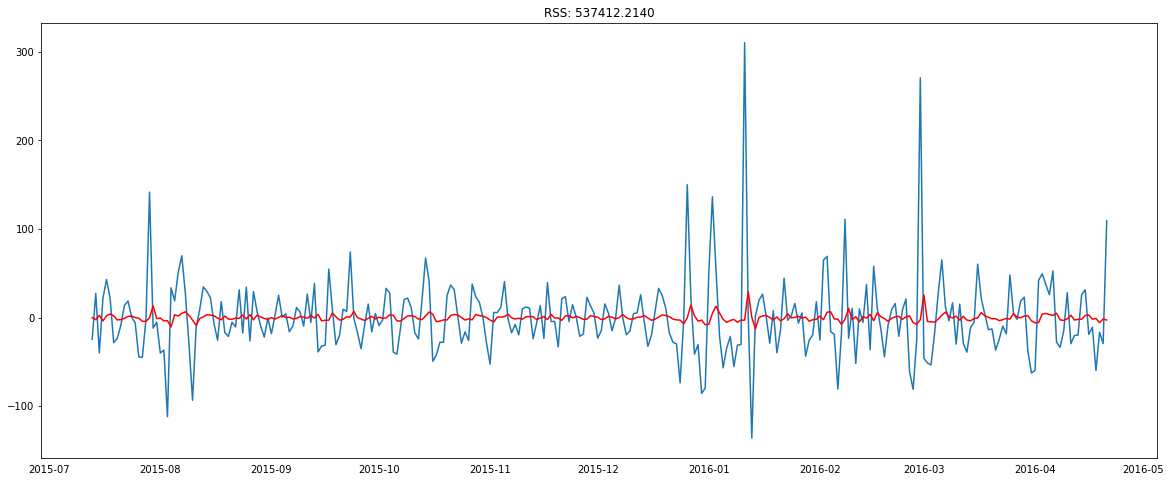

In [ ]:
model = ARIMA(residual, order=(1, 0, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(residual)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-residual)**2))

## MA

/usr/local/lib/python2.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Text(0.5,1,'RSS: 533371.8529')

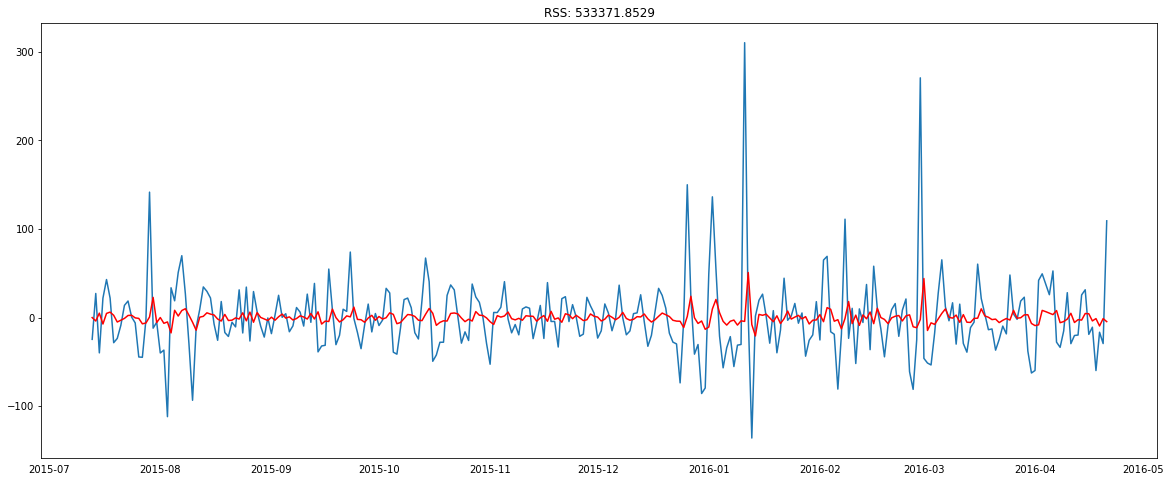

In [ ]:
model = ARIMA(residual, order=(0, 0, 1))  
results_MA = model.fit(disp=-1)  
plt.plot(residual)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-residual)**2))

## ARMA

/usr/local/lib/python2.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Text(0.5,1,'RSS: 420239.3128')

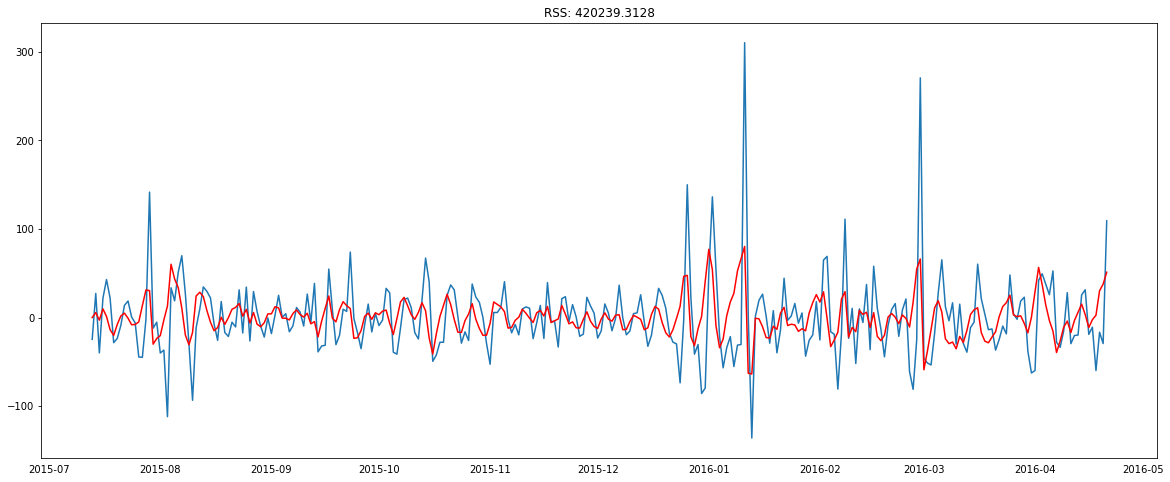

In [ ]:
model = ARIMA(residual, order=(1, 0, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(residual)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-residual)**2))

## Grid search for p, q

In [ ]:
mat_aic = np.zeros((5,5))
for p in range(1, 6):
  for q in range(1, 6):
    try:
      model = ARIMA(residual, order=(p, 0, q))  
      results_ARIMA = model.fit(disp=-1)  
      mat_aic[p-1][q-1] = results_ARIMA.aic
    except:
      print "not invertible"
    

In [ ]:
mat_aic

array([[2887.99188993,    0.        ,    0.        ,    0.        ,
           0.        ],
       [   0.        , 2827.50600788,    0.        ,    0.        ,
           0.        ],
       [2828.18895924, 2829.48310631, 2831.21974247, 2833.0769175 ,
           0.        ],
       [2829.63039784, 2831.44436791, 2833.16165032, 2832.69584094,
           0.        ],
       [2830.69170007, 2831.95191029, 2831.54453358, 2830.72072829,
        2832.71505926]])

/usr/local/lib/python2.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


2827.50600788


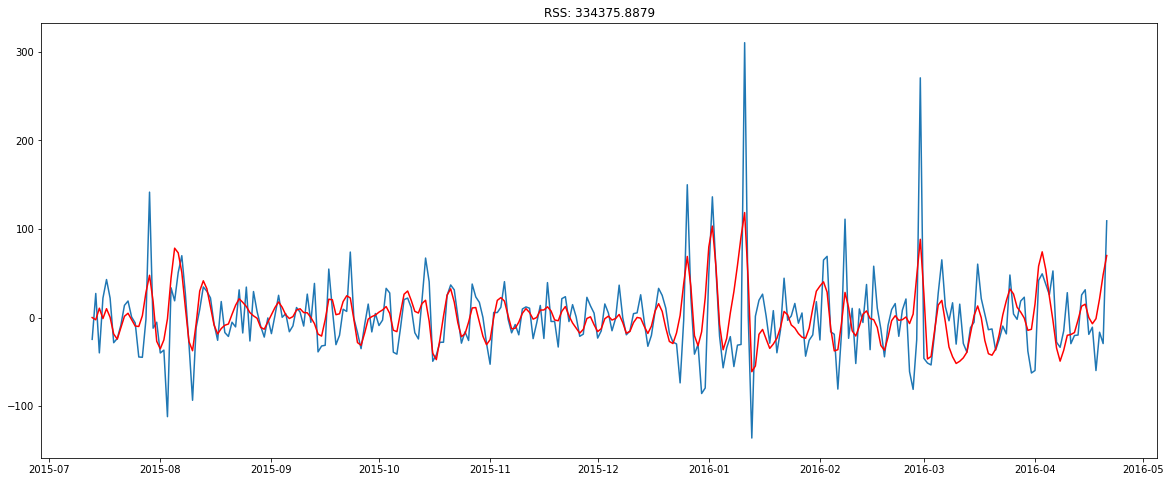

In [ ]:
model = ARIMA(residual, order=(2, 0, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(residual)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-residual)**2))
print results_ARIMA.aic

## Take it back to original scale

In [ ]:
predictions_ARIMA = pd.Series(results_ARIMA.fittedvalues, copy=True)
print predictions_ARIMA.head()

date
2015-07-13    -0.003742
2015-07-14    -2.493793
2015-07-15    10.567714
2015-07-16    -1.075347
2015-07-17    10.030801
dtype: float64


In [ ]:
predictions_all = pd.Series(0, index=mean_group.index)
predictions_all = predictions_all.add(trend).add(seasonal).add(predictions_ARIMA)
print predictions_all.head()

date
2015-07-10            NaN
2015-07-11            NaN
2015-07-12            NaN
2015-07-13    1324.832741
2015-07-14    1267.528779
dtype: float64


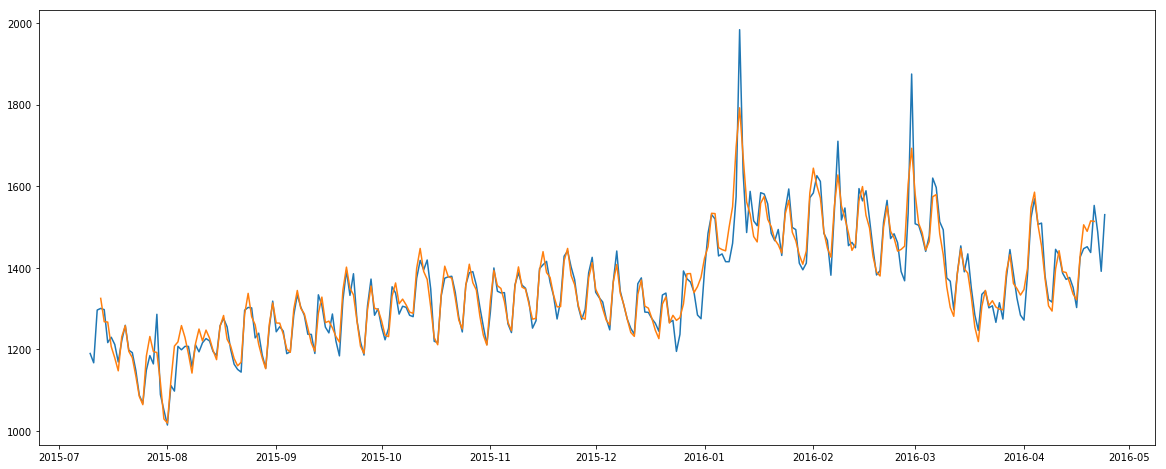

In [ ]:
plt.plot(mean_group)
plt.plot(predictions_all)